In [72]:
import pandas as pd
import os
import json
import numpy as np
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
from nameparser import HumanName
from ethnicolr import pred_census_ln
from itertools import combinations
from collections import Counter, defaultdict
from matplotlib.lines import Line2D
from scipy.stats import zscore
from collections import Counter


In [73]:
path_connected_data = "C:\\Users\\tykun\\OneDrive\\Documents\\SchoolDocs\\VSCodeProjects\\connectedData\\dataframes\\"
path_temp_data = "C:\\Users\\tykun\\OneDrive\\Documents\\SchoolDocs\\VSCodeProjects\\connectedData\\temporaryData\\"
year = "2009"
valid_years = ["1999", "2000", "2005", "2008", "2009", "2013"]

path_read = f"{path_connected_data}{year}_split_positions.csv"
boards_path = f"{path_temp_data}{year}_boards.csv"
interlocked_boards_path = f"{path_temp_data}interlocked_boards.csv"
interlocked_nodes_path = f"{path_temp_data}interlocked_nodes.csv"
interlocked_edges_path = f"{path_temp_data}interlocked_edges.csv"
bipartite_nodes_path = f"{path_temp_data}bipartite_nodes.csv"
bipartite_edges_path = f"{path_temp_data}bipartite_edges.csv"
interlock_stats = f"{path_temp_data}interlocking_stats.csv"


In [74]:
# Dictionary to store average turnover by year after filtering out outliers
average_turnover_by_year = {}

previous_year_boards = {}  # To store the previous year's boards data by institution

for year in valid_years:
    # Read the CSV file for the current year
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    
    # Group by institution
    grouped_boards = boards_df.groupby("Institution")
    
    year_turnover = {}
    
    for institution, group in grouped_boards:
        if "Name" in group.columns:
            # If previous year data exists for this institution
            if institution in previous_year_boards:
                previous_members = previous_year_boards[institution]
                current_members = set(group["Name"])
                
                # Calculate turnover as the proportion of new members
                new_members = current_members - previous_members
                turnover_rate = len(new_members) / len(current_members) if len(current_members) > 0 else 0
                year_turnover[institution] = turnover_rate
            
            # Update the previous year's members for this institution
            previous_year_boards[institution] = set(group["Name"])
    
    # Filter out outliers more than 1 standard deviation above the mean
    if year_turnover:
        turnover_values = np.array(list(year_turnover.values()))
        mean_turnover = np.mean(turnover_values)
        std_dev_turnover = np.std(turnover_values)
        
        # Filter institutions to exclude those more than 1 standard deviation above the mean
        filtered_turnover = {inst: rate for inst, rate in year_turnover.items() 
                             if rate <= (mean_turnover + std_dev_turnover)}
        
        # Calculate the average turnover for filtered institutions
        if filtered_turnover:
            average_turnover_by_year[year] = sum(filtered_turnover.values()) / len(filtered_turnover)
        else:
            average_turnover_by_year[year] = None  # Handle case where filtering removes all data
    else:
        average_turnover_by_year[year] = None  # Handle case where there might be no data

# Convert the dictionary to a DataFrame for easier analysis and plotting
average_turnover_df = pd.DataFrame(list(average_turnover_by_year.items()), columns=['Year', 'Average Turnover'])

# Display the result
print(average_turnover_df)

   Year  Average Turnover
0  1999               NaN
1  2000          0.258626
2  2005          0.605241
3  2008          0.454689
4  2009          0.214975
5  2013          0.586032


In [75]:
# Dictionary to store institutions with the highest turnover by year
institutions_with_highest_turnover_by_year = {}

previous_year_boards = {}  # To store the previous year's boards data by institution

for year in valid_years:
    # Read the CSV file for the current year
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    
    # Group by institution
    grouped_boards = boards_df.groupby("Institution")
    
    year_turnover = {}
    turnover_counts = {}  # To store the number of changes for each institution
    
    for institution, group in grouped_boards:
        if "Name" in group.columns:
            # If previous year data exists for this institution
            if institution in previous_year_boards:
                previous_members = previous_year_boards[institution]
                current_members = set(group["Name"])
                
                # Calculate turnover as the proportion of new members
                new_members = current_members - previous_members
                turnover_rate = len(new_members) / len(current_members) if len(current_members) > 0 else 0
                year_turnover[institution] = turnover_rate
                turnover_counts[institution] = len(new_members)  # Record the number of new members
            
            # Update the previous year's members for this institution
            previous_year_boards[institution] = set(group["Name"])
    
    # Sort institutions by turnover rate and then by number of changes
    sorted_institutions = sorted(year_turnover.items(), key=lambda x: (-x[1], -turnover_counts[x[0]]))
    
    # Select the top 3 institutions with the highest turnover
    top_institutions = [(inst, turnover_counts[inst]) for inst, turnover in sorted_institutions[:7]]
    
    institutions_with_highest_turnover_by_year[year] = top_institutions

# Print the result
for year, institutions in institutions_with_highest_turnover_by_year.items():
    if institutions:
        print(f"\nYear {year}: Institutions with highest turnover -")
        for inst, changes in institutions:
            print(f"  {inst} with {changes} changes")
    else:
        print(f"Year {year}: No data available or no institutions with turnover.")

Year 1999: No data available or no institutions with turnover.

Year 2000: Institutions with highest turnover -
  Loyola Marymount University with 56 changes
  Wheaton College Massachusetts with 30 changes
  Middle Tennessee State University with 19 changes
  Wheaton College Illinois with 18 changes
  College Of Charleston with 17 changes
  Louisiana State University System with 16 changes
  Ohio University with 12 changes

Year 2005: Institutions with highest turnover -
  College Of William And Mary with 19 changes
  James Madison University with 16 changes
  Virginia Commonwealth University with 15 changes
  Citadel with 14 changes
  University Of Akron with 13 changes
  University Of Hawaii System with 11 changes
  Cleveland State University with 10 changes

Year 2008: Institutions with highest turnover -
  Loyola College In Maryland with 26 changes
  Louisiana State University System with 17 changes
  University Of Louisiana System with 16 changes
  University Of Illinois with 13 c

In [76]:
institutions_with_highest_turnover_by_year = {}
previous_year_boards = {}
all_turnover_data = [] 

for year in valid_years:
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    grouped_boards = boards_df.groupby("Institution")
    year_turnover = {}
    turnover_counts = {} 

    for institution, group in grouped_boards:
        if "Name" in group.columns:
            if institution in previous_year_boards:
                previous_members = previous_year_boards[institution]
                current_members = set(group["Name"])
                
                # Calculate turnover as the proportion of new members
                new_members = current_members - previous_members
                turnover_rate = len(new_members) / len(current_members) if len(current_members) > 0 else 0
                year_turnover[institution] = turnover_rate
                turnover_counts[institution] = len(new_members)  # Record the number of new members
                # Store the data for Z-score calculation
                all_turnover_data.append((institution, year, turnover_rate))
            
            # Update the previous year's members for this institution
            previous_year_boards[institution] = set(group["Name"])

# Convert the turnover data to a DataFrame for easier Z-score calculation
turnover_df = pd.DataFrame(all_turnover_data, columns=['Institution', 'Year', 'TurnoverRate'])
turnover_df['ZScore'] = zscore(turnover_df['TurnoverRate'])
filtered_turnover_df = turnover_df[np.abs(turnover_df['ZScore']) <= 1.0]
# Group by institution and calculate the average turnover after removing outliers
average_turnover_by_institution = filtered_turnover_df.groupby('Institution')['TurnoverRate'].mean()

# Sort the institutions by average turnover and select the top 7
top_institutions = average_turnover_by_institution.sort_values(ascending=False).head(30)

print("Institutions with the highest average turnover (after excluding outliers):")
for institution, avg_turnover in top_institutions.items():
    print(f"{institution}: {avg_turnover:.2f} average turnover")

Institutions with the highest average turnover (after excluding outliers):
Samford University: 0.70 average turnover
Montana University System: 0.70 average turnover
Texas Tech University System: 0.70 average turnover
University Of Denver: 0.68 average turnover
Stephen F Austin State University: 0.68 average turnover
College Of St Scholastica: 0.68 average turnover
Southern Illinois University System: 0.67 average turnover
Harvard University: 0.66 average turnover
Nevada System Of Higher Education: 0.65 average turnover
Queens University Of Charlotte: 0.65 average turnover
Louisiana State University System: 0.65 average turnover
University Of Oklahoma: 0.64 average turnover
University Of North Carolina At Pembroke: 0.64 average turnover
University Of Pennsylvania: 0.64 average turnover
Slippery Rock University Of Pennsylvania: 0.64 average turnover
Villanova University: 0.64 average turnover
Middlebury College: 0.64 average turnover
Clemson University: 0.63 average turnover
Murray Stat

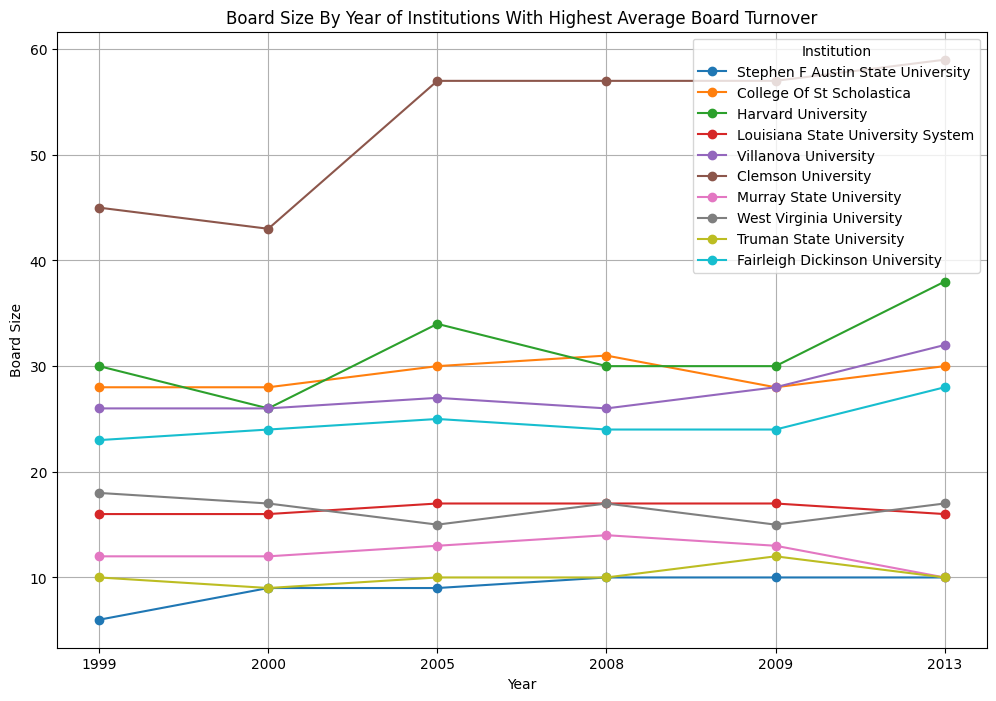

In [77]:
plt.figure(figsize=(12, 8))

for institution in top_institutions.index:
    board_sizes = []
    for year in valid_years:
        boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
        institution_df = boards_df[boards_df['Institution'] == institution]
        board_size = institution_df['Name'].nunique()  # Get the number of unique board members
        board_sizes.append(board_size)
    
    # Skip plotting if the institution has a board size of 0 at any time
    if 0 in board_sizes:
        continue
    
    # Plot each institution's board size over time
    plt.plot(valid_years, board_sizes, marker='o', label=institution)

# Customizing the plot
plt.title('Board Size By Year of Institutions With Highest Average Board Turnover')
plt.xlabel('Year')
plt.ylabel('Board Size')
plt.legend(title='Institution', loc='best')
plt.grid(True)

# Show the plot
plt.show()

In [78]:
current_university = "Swarthmore College"

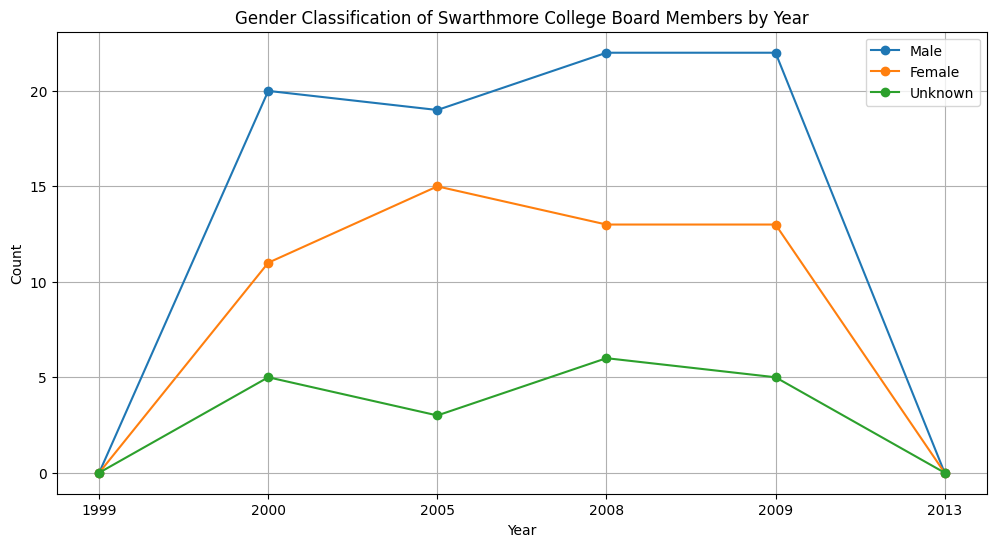

In [79]:
d = gender.Detector()
numbers_by_year = {}
for year in valid_years:
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    harvard_df = boards_df[boards_df["Institution"] == f'{current_university}']
    current_year_dict = {'male': 0, 'female': 0, 'unknown': 0, "andy": 0}

    for index, row in harvard_df.iterrows():
        name = HumanName(row["Name"])
        first_name = str(name.first)
        institution = row["Institution"]
        current_gender = d.get_gender(first_name)
        if current_gender in ['male', 'female']:
            current_year_dict[current_gender] += 1
        else:
            current_year_dict['unknown'] += 1
    numbers_by_year[year] = current_year_dict

df = pd.DataFrame(numbers_by_year).T

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['male'], label='Male', marker='o')
plt.plot(df.index, df['female'], label='Female', marker='o')
plt.plot(df.index, df['unknown'], label='Unknown', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title(f"Gender Classification of {current_university} Board Members by Year")
plt.legend()
plt.grid(True)
plt.show()

No valid data for Swarthmore College in year 1999
No valid data for Swarthmore College in year 2013


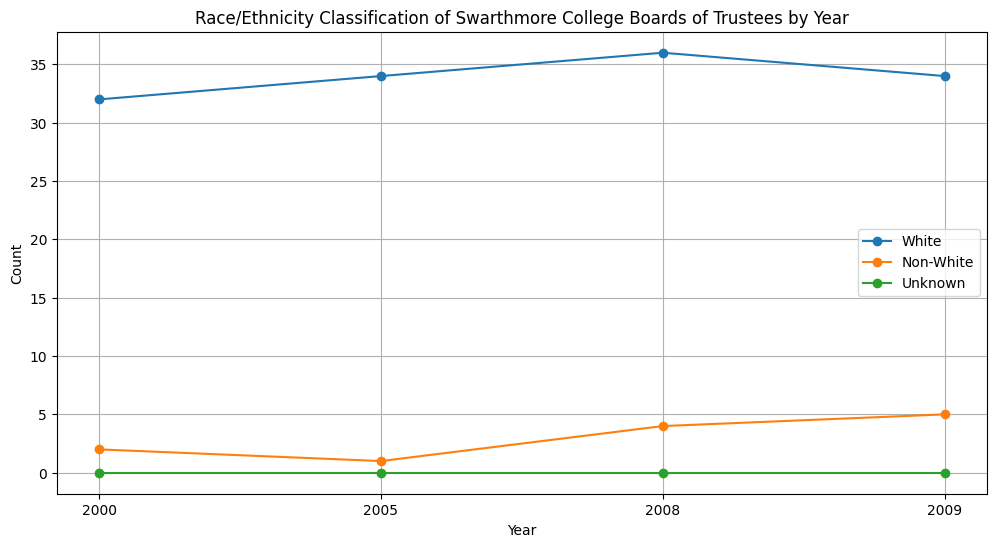

In [80]:
def get_last_name(full_name):
    full_name = HumanName(full_name)
    return str(full_name.last)

d = gender.Detector()
numbers_by_year = {}

for year in valid_years:
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    harvard_df = boards_df[boards_df["Institution"] == f'{current_university}'].copy()

    # Apply the function to get last names using .loc to avoid the warning
    harvard_df.loc[:, 'last_name'] = harvard_df['Name'].apply(get_last_name)

    # Debug: Check for NaN values in the last_name column
    if harvard_df['last_name'].isna().sum() > 0:
        print(f"Warning: {harvard_df['last_name'].isna().sum()} NaN values found in last_name column for year {year}")
        # Option 1: Drop rows with NaN values in last_name
        harvard_df = harvard_df.dropna(subset=['last_name'])
        # Option 2: Replace NaN values with a placeholder (e.g., 'Unknown')
        # harvard_df['last_name'].fillna('Unknown', inplace=True)
    
    # Now apply the ethnicity prediction model
    if not harvard_df.empty:
        harvard_df = pred_census_ln(harvard_df, 'last_name')
    else:
        print(f"No valid data for {current_university} in year {year}")
        continue

    current_year_dict = {'white': 0, 'poc': 0, 'unknown': 0}

    for index, row in harvard_df.iterrows():
        ethnicity = row['race']  # Use the correct column name
        if ethnicity == 'white':
            current_year_dict['white'] += 1
        elif ethnicity in ['api', 'black', 'hispanic', 'aian']:
            current_year_dict['poc'] += 1
        else:
            current_year_dict['unknown'] += 1
    
    # Add the current year's dictionary to the numbers_by_year dictionary
    numbers_by_year[year] = current_year_dict

# Convert the dictionary to a DataFrame for easier plotting
df = pd.DataFrame(numbers_by_year).T

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['white'], label='White', marker='o')
plt.plot(df.index, df['poc'], label='Non-White', marker='o')
plt.plot(df.index, df['unknown'], label='Unknown', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title(f"Race/Ethnicity Classification of {current_university} Boards of Trustees by Year")
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Create an empty list to store instances of board interlocking
interlocking_boards_list = []

# Create Counters to track the frequency of institutions and institution pairs
institution_counter = Counter()
institution_pair_counter = Counter()

for year in valid_years:
    # Load the CSV for the current year
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    
    # Group by the "Name" column to find duplicates across different institutions
    grouped = boards_df.groupby('Name')
    
    for name, group in grouped:
        # Check if the individual appears in more than one institution
        if group['Institution'].nunique() > 1:
            # Store the information about the interlock
            institutions = group['Institution'].unique().tolist()
            interlocking_boards_list.append({
                'Year': year,
                'Name': name,
                'Institutions': institutions
            })
            
            # Update the institution counter
            institution_counter.update(institutions)
            
            # Update the institution pair counter for each combination of interlocking institutions
            if len(institutions) > 1:
                for combo in combinations(sorted(institutions), 2):
                    institution_pair_counter.update([combo])

# Convert the list of interlocking instances to a DataFrame
interlocking_boards = pd.DataFrame(interlocking_boards_list)

# Display the most common institutions involved in interlocks
print("\nMost Common Institutions in Interlocking Boards:")
for institution, count in institution_counter.most_common():
    print(f"{institution}: {count} times")

# Display the most common institution pairs involved in interlocks
print("\nMost Common Institution Pairs in Interlocking Boards:")
for pair, count in institution_pair_counter.most_common():
    print(f"{pair[0]} & {pair[1]}: {count} times")


Most Common Institutions in Interlocking Boards:
Utah State University: 83 times
University Of Utah: 83 times
Weber State University: 82 times
East Tennessee State University: 75 times
Tennessee State University: 67 times
Middle Tennessee State University: 66 times
University Of Memphis: 62 times
Tennessee Technological University: 62 times
Arizona State University: 55 times
Northern Arizona University: 53 times
University Of Arizona: 50 times
Minnesota State University Mankato: 48 times
University Of Kansas: 47 times
Kansas State University: 45 times
Wichita State University: 44 times
University Of Northern Iowa: 43 times
Austin Peay State University: 43 times
Emporia State University: 43 times
Iowa State University: 42 times
University Of Iowa: 40 times
Rockefeller University: 39 times
Minnesota State University Moorhead: 39 times
Pennsylvania State System Of Higher Education: 37 times
Austin Pay State University: 37 times
Massachusetts Institute Of Technology: 33 times
University O

In [82]:
# Dictionary to store board members and their institutions across all years
board_member_dict = defaultdict(set)
edges_list = []
nodes_dict = defaultdict(int)

# Iterate through each year
for year in valid_years:
    boards_path = f"{path_temp_data}{year}_boards.csv"
    boards_df = pd.read_csv(boards_path)

    # Iterate over each board member
    for index, row in boards_df.iterrows():
        name = row['Name']
        institution = row['Institution']
        
        # If this board member has been seen before in a different institution, record an interlock
        for previous_institution in board_member_dict[name]:
            if previous_institution != institution:
                # Record the interlock as an edge
                edges_list.append({
                    'Source': previous_institution,
                    'Target': institution,
                    'Type': 'Undirected',
                    'Weight': 1  # Each interlock counts as 1 by default
                })
                # Increment the interlock count for the involved institutions
                nodes_dict[previous_institution] += 1
                nodes_dict[institution] += 1
                
        # Add the current institution to the set of institutions this member is associated with
        board_member_dict[name].add(institution)

# Create a DataFrame for nodes (universities) with their interlock counts
nodes_df = pd.DataFrame(list(nodes_dict.items()), columns=['Id', 'Interlock_Count'])
nodes_df['Label'] = nodes_df['Id']  # Use the institution name as the label

# Create a DataFrame for edges (interlocks between institutions)
edges_df = pd.DataFrame(edges_list)

# Save the DataFrames to CSV files
nodes_df.to_csv(interlocked_nodes_path, index=False)
edges_df.to_csv(interlocked_edges_path, index=False)

In [85]:

# Define lists to store information about board interlocks and network edges
interlocking_boards_list = []
edges_list = []
institution_interlocks = defaultdict(set)  # To track unique interlocks per institution

# Iterate over each year
for year in valid_years:
    # Load the CSV for the current year
    boards_df = pd.read_csv(f"{path_temp_data}{year}_boards.csv")
    
    # Group by the "Name" column to find individuals who serve on multiple boards
    grouped = boards_df.groupby('Name')
    
    for name, group in grouped:
        # Get a list of all unique institutions this individual is part of across all years
        institutions = group['Institution'].unique().tolist()
        
        # Check if the individual serves on more than one institution
        if len(institutions) > 1:
            # Store the information about the interlock
            interlocking_boards_list.append({
                'Name': name,
                'Institutions': institutions
            })
            
            # Track interlocks between institutions
            for i in range(len(institutions)):
                for j in range(i + 1, len(institutions)):
                    institution_interlocks[institutions[i]].add(institutions[j])
                    institution_interlocks[institutions[j]].add(institutions[i])

# Calculate the number of interlocks for each institution
institution_interlock_counts = {institution: len(interlocks) for institution, interlocks in institution_interlocks.items()}

# Include institutions with zero interlocks
all_institutions = set(boards_df['Institution'].unique())
for institution in all_institutions:
    if institution not in institution_interlock_counts:
        institution_interlock_counts[institution] = 0

# Convert to DataFrame for easier analysis
institution_interlock_df = pd.DataFrame(list(institution_interlock_counts.items()), columns=['Institution', 'Interlock_Count'])

# Calculate mean and standard deviation
mean_interlocks = institution_interlock_df['Interlock_Count'].mean()
std_interlocks = institution_interlock_df['Interlock_Count'].std()

# Calculate the number of standard deviations from the mean for each institution
institution_interlock_df['Std_Devs_From_Mean'] = (institution_interlock_df['Interlock_Count'] - mean_interlocks) / std_interlocks


institution_interlock_df = institution_interlock_df.sort_values(by="Std_Devs_From_Mean", ascending = False)
institution_interlock_df.to_csv(interlock_stats, index = False)